In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import xml.etree.ElementTree as ET
import torch.nn as nn
import torch.nn.functional as F
cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/datasets/dataloader.zip -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_259.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_264.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_265.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_268.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_269.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_274.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_277.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_279.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_280.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_288.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_289.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_298.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_304.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_315.xml  
  inflating: /content/data/val/box/Bull_Dog/Bull_Dog_320.

In [4]:
clases = ['Afgano','Beagle','Bull_Dog','Collie','Cooker','German_Pointer','Golden_retriever','Pug','Schnauzer']

In [5]:
len(clases)

9

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
class CustomDataset(Dataset):
    def __init__(self,data_path,clases,flag='train',transforms=None):
        self.flag=flag
        self.transform = None
        if transforms != None:
            self.transform= transforms[self.flag]
        self.path=data_path
        self.clases=clases
        self.box=[]
        self.image={}
        self.mask={}
        self.clasesDic={}
        self.iniciar()

    def iniciarClases(self):
        for x in range(0,len(self.clases)):
            self.clasesDic[self.clases[x]]=x

    def __len__(self):
        contador=len(self.box)

        return contador


    def iniciar(self):
        self.iniciarClases()
        self.buscarXml()
        self.buscarImagenes()

    def findBox(self,data):
        coordenadas = data.find('object').find("bndbox")
        xmin = float(coordenadas.find('xmin').text)
        ymin = float(coordenadas.find('ymin').text)
        xmax = float(coordenadas.find('xmax').text)
        ymax = float(coordenadas.find('ymax').text)
        return torch.tensor([xmin,ymin,xmax,ymax])/50

    def findData(self,data):
        name = data.find("object").find('name').text
        label = data.find("filename").text
        return [name,label]


    def buscarImagenes(self):

        for data in self.box:
            clase = data.find("object").find("name").text
            nombre = data.find('filename').text
            self.image[nombre] = self.path+"/"+self.flag+"/"+"image/"+clase+"/"+nombre
            self.mask[nombre] = self.path+"/"+self.flag+"/"+"mask/"+clase+"/"+nombre[:-3]+"png"
                    #self.image[nombre]=Image.open(self.path+"/"+carpeta+"/"+"image/"+clase+"/"+nombre)
                    #self.mask[nombre]=Image.open(self.path+"/"+carpeta+"/"+"mask/"+clase+"/"+nombre[:-3]+"png")

    def buscarXml(self):
        for clase in self.clases:
            self.box= self.box+self.parse_xml(self.path+"/"+self.flag+"/box/"+clase)


    def parse_xml(self,path):
        xml_trees = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith(".xml"):
                    xml_file_path = os.path.join(root, file)
                    xml_tree = ET.parse(xml_file_path)
                    xml_trees.append(xml_tree)
        return xml_trees
    def findImg(self,nombre):
        image = self.image[nombre]
        mask = self.mask[nombre]
        image = Image.open(image)
        mask = Image.open(mask)
        return image,mask

    def __getitem__(self,idx):
        elemento = self.box[idx]
        box = self.findBox(elemento)
        data = self.findData(elemento)
        image,mask = self.findImg(data[1])
        if self.transform != None:
            image = self.transform(image)
            mask = self.transform(mask)
        return box,self.clasesDic[data[0]],image,mask


In [9]:
dataTrain = CustomDataset("/content/data",clases,flag='train',transforms=data_transforms)

In [10]:
dataVal = CustomDataset("/content/data",clases,flag="val",transforms=data_transforms)

In [11]:
#dataloaders
num_workers = 6
batch_size = 250
dataloaders = {'train': torch.utils.data.DataLoader(dataTrain, batch_size=batch_size,num_workers=num_workers,
                                             shuffle=True),
               'val':torch.utils.data.DataLoader(dataVal, batch_size=batch_size,num_workers=num_workers,
                                             shuffle=True)
              }

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
dataset_sizes = {"train":dataTrain.__len__(),"val":dataVal.__len__()}

In [13]:
clases

['Afgano',
 'Beagle',
 'Bull_Dog',
 'Collie',
 'Cooker',
 'German_Pointer',
 'Golden_retriever',
 'Pug',
 'Schnauzer']

In [14]:
len(dataVal.box)

1800

In [15]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


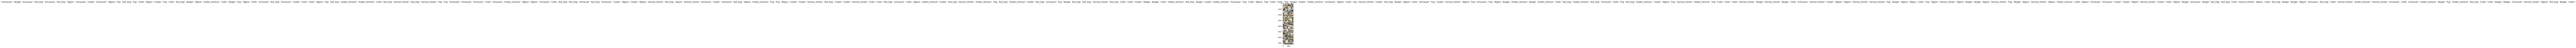

In [16]:
# Get a batch of training data
boxes, clasesOP, inputs,masks = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[clases[x] for x in clasesOP])

In [17]:
boxes

tensor([[0.2920, 0.1260, 0.7200, 0.9320],
        [0.1774, 0.0954, 0.5432, 0.8960],
        [0.0380, 0.2140, 0.7220, 0.8220],
        [0.1020, 0.2620, 0.8220, 0.9420],
        [0.4000, 0.3020, 0.8600, 0.7680],
        [0.1020, 0.0820, 0.7620, 0.9620],
        [0.0488, 0.0316, 0.9274, 0.9700],
        [0.0220, 0.0660, 0.9320, 0.9640],
        [0.1040, 0.1660, 0.8180, 0.9040],
        [0.1880, 0.2740, 0.7360, 0.9500],
        [0.0508, 0.0760, 0.9550, 0.9800],
        [0.0760, 0.2300, 0.8600, 0.8120],
        [0.1020, 0.1020, 0.9220, 1.0220],
        [0.1840, 0.1480, 0.8160, 0.8340],
        [0.0288, 0.0000, 1.0000, 0.9806],
        [0.2750, 0.1040, 0.9510, 0.9640],
        [0.2020, 0.0960, 0.7680, 0.9420],
        [0.4820, 0.2140, 0.9180, 0.7340],
        [0.3456, 0.3730, 0.6596, 0.7560],
        [0.3020, 0.0420, 0.7620, 0.7620],
        [0.2798, 0.1292, 0.7718, 0.8872],
        [0.0848, 0.1012, 0.9538, 0.8860],
        [0.0408, 0.2820, 0.5690, 0.8140],
        [0.0172, 0.0100, 0.9850, 0

In [18]:
def train_model(model, num_epochs=25):
    since = time.time()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler =lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for boxes, labels ,inputs ,masks in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    boxes = boxes.to(device)
                    # zero the parameter gradients

                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs,boxesOP = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        criterioClas=nn.CrossEntropyLoss()
                        criterioDetec=nn.L1Loss()
                        lossClas =  criterioClas(outputs,labels)
                        #print(boxes.shape)
                        #print(type(boxesOP))
                        lossDetec = criterioDetec(boxes,boxesOP)
                        loss = lossClas+lossDetec

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (boxes, labels ,inputs ,masks) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            boxes = boxes.to(device)
            outputs, oBoxes = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {clases[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


In [21]:
model_ft.fc.in_features

512

In [22]:
class BlocFinal(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linearPre = nn.Linear(512,9)
        self.linearBox = nn.Linear(512,4)
        #self.flaten = torch.flatten()


    def forward(self,x):
        #x = torch.flatten(x)
        return self.linearPre(x),self.linearBox(x)

In [23]:
#definimos el modelo
class CustomModel(torch.nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
        self.final = BlocFinal()



    def forward(self,x):
        self.model.fc= self.final


In [24]:
#model_ft.fc = nn.Identity()
#model_ft.fc=nn.Linear(512,9)
#model_ft.fc2=nn.Linear(512,4)

In [25]:

capa = BlocFinal()
model_ft.fc = capa

In [26]:
modelFinal = model_ft

In [27]:
inputs.shape

torch.Size([250, 3, 224, 224])

In [28]:
modelFinal.to(device)
modelFinal = train_model(modelFinal,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5221 Acc: 0.2319
val Loss: 2.0957 Acc: 0.4433

Epoch 1/24
----------
train Loss: 1.8971 Acc: 0.4739
val Loss: 1.5479 Acc: 0.6056

Epoch 2/24
----------
train Loss: 1.5581 Acc: 0.5635
val Loss: 1.2384 Acc: 0.6783

Epoch 3/24
----------
train Loss: 1.3261 Acc: 0.6261
val Loss: 1.0382 Acc: 0.7483

Epoch 4/24
----------
train Loss: 1.1873 Acc: 0.6631
val Loss: 0.9364 Acc: 0.7628

Epoch 5/24
----------
train Loss: 1.0893 Acc: 0.6899
val Loss: 0.8461 Acc: 0.7850

Epoch 6/24
----------
train Loss: 0.9997 Acc: 0.7199
val Loss: 0.7568 Acc: 0.8144

Epoch 7/24
----------
train Loss: 0.9601 Acc: 0.7273
val Loss: 0.7268 Acc: 0.8172

Epoch 8/24
----------
train Loss: 0.9516 Acc: 0.7259
val Loss: 0.7155 Acc: 0.8206

Epoch 9/24
----------
train Loss: 0.9299 Acc: 0.7320
val Loss: 0.7095 Acc: 0.8239

Epoch 10/24
----------
train Loss: 0.9209 Acc: 0.7377
val Loss: 0.7030 Acc: 0.8256

Epoch 11/24
----------
train Loss: 0.9300 Acc: 0.7351
val Loss: 0.6975 Acc: 0.8283

Ep

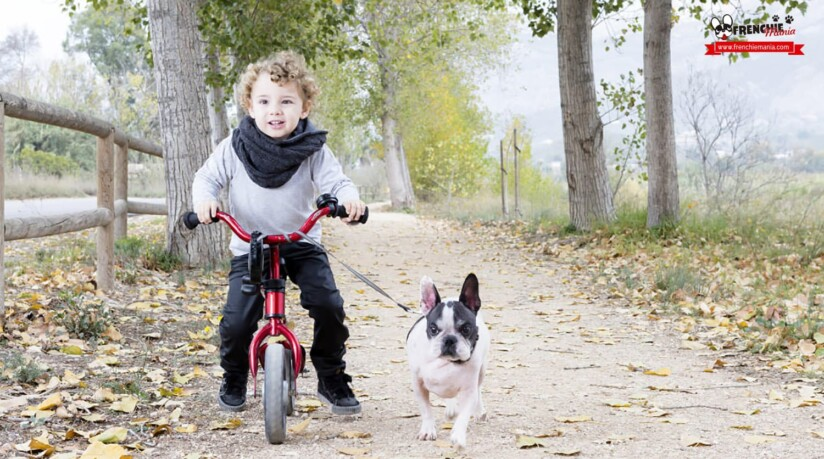

In [87]:
imagenPrueba = Image.open("/content/vesd.jpg")
imagenPrueba

In [88]:
parseimg=data_transforms['val'](imagenPrueba)

In [89]:
parseimg=torch.unsqueeze(parseimg,0)

In [90]:
dataPrueba = modelFinal(parseimg.to('cuda'))

In [91]:
dataPrueba[1][0][0]

tensor(0.2135, device='cuda:0', grad_fn=<SelectBackward0>)

In [94]:
dataPrueba = dataPrueba[1][0].to('cpu')

In [95]:
dataPrueba=dataPrueba.detach().numpy()

In [96]:
dataPrueba

array([ 0.21347377, -0.18700212,  0.9082602 ,  0.9639466 ], dtype=float32)

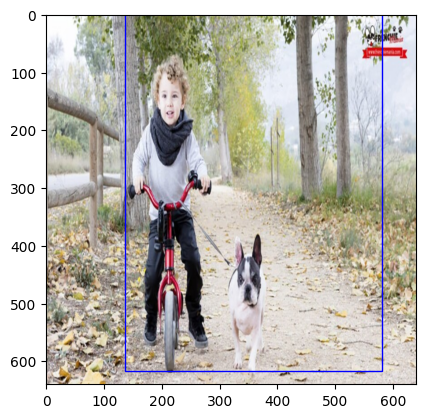

In [97]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# Coordenadas del rectángulo
xmin = dataPrueba[0]*640
ymin = dataPrueba[1]*640
xmax = dataPrueba[2]*640
ymax = dataPrueba[3]*640

# Cargar la imagen
image = Image.open("/content/vesd.jpg")
image = image.resize((640,640))

# Crear una figura y un objeto Axes
fig, ax = plt.subplots()

# Añadir la imagen al objeto Axes
ax.imshow(image)

# Dibujar el rectángulo
rectangle = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='blue', facecolor='red',fill=False)
ax.add_patch(rectangle)

# Mostrar el gráfico
plt.show()